# LSTM Model for Water Dam Capacity Forecasting (Daily Frequency)

**Author**: Ricardo Pérez Castillo  
**Date**: 2020-06-01  
**Purpose**: Develop an LSTM-based time series model to forecast daily water dam capacity level for improved resource management and planning.  
**Keywords**: LSTM, Time Series Forecasting, Water Management, Machine Learning  

Walkthrough video explaining step by step how to reproduce the notebook (no longer functional):
https://www.loom.com/share/5b87cb54e4ee4362a88fafb309b635a5

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Description](#Data-Description)
3. [Data Exploration and Preprocessing](#Data-Preprocessing)
4. [Model Design](#Model-Design)
5. [Model Training and Validation](#Model-Training-and-Validation)
6. [Results and Analysis](#Results-and-Analysis)
7. [Conclusion](#Conclusion)

## Introduction

The state of Nuevo León, where the metropolitan area of Monterrey is located, provides its citizens with water from different sources. These can be segmented into two main categories: surface (57%) and underground (43%). Surface water sources include three main dams: La Boca, Cerro Prieto, and El Cuchillo. Underground sources are primarily wells and natural springs. While specific figures vary, Monterrey’s groundwater supply is supported by multiple wellfields across the state.

This project develops a Long Short-Term Memory (LSTM) model to forecast daily water dam capacity based on historical data. LSTM models are well-suited for time series analysis due to their ability to capture long-term dependencies.

This notebook includes:
1. Data exploration and preprocessing.
2. LSTM model design and implementation.
3. Performance evaluation using statistical metrics.
4. Insights and recommendations for water management.

## Data Description

This dataset contains daily observations for the three main water dams and meteorological variables, spanning from **2004 to 2019**. The target variable for forecasting is **Volume Capacity (million cubic meters)**, representing the total capacity of each dam.

### Key Characteristics:
- **Time Period**: January 1, 2004, to December 31, 2019
- **Frequency**: Daily
- **Total Data Points**: 5,836
- **Total Features**: 2

### Variables Description
The features are categorized as follows:

#### **Temporal Features**
- **Date**: Recorded in `Day-Month-Year` format.

#### **Target Variable**
- **Nivel**: Water Dam Capacity, or water level measured in millions of cubic meters.
  *This is the feature we aim to forecast.*

#### **Meteorological Features**
- **Rain**: Accumulated Rainfall in the area, measured in cm.

---

### Data Sources
The dataset was sourced from Comisión Nacional del Agua (CONAGUA).


## Data Exploration and Preprocessing

#### **Objective**
The goal of this section is to explore the dataset, transform it into a supervised learning format suitable for LSTM models, and preprocess the data to meet the requirements of the model training phase. The process involves the following steps:

1. **Understanding the Structure of the Dataset**
   - Identify the key features and their roles in the analysis.
   - Check for missing values and other potential data quality issues.

2. **Feature Engineering**
   - Transform the time-series dataset into a supervised learning format.
   - Generate lagged features to account for temporal dependencies.

3. **Normalization**
   - Scale the dataset to ensure that the features have zero mean and unit variance.

3. **Split dataset into train and test**
   - The split ensures that the model is trained and evaluated on separate data, which is essential for unbiased performance assessment. We will split with 12 years for training and 3 year for testing.

In [1]:
# Basic Libraries
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Pandas
import pandas as pd
from pandas import read_csv, DataFrame, concat

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# Tensorflow
import tensorflow as tf

# Seaborn for Graphs
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
# Connection to Google Drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Read data
root_path = '/content/gdrive/MyDrive/Digital Water/notebooks/water dam capacity/water dam 1/'

dataset = read_csv(root_path+"water-dam-C-capacity-data.csv", parse_dates=['Date'], index_col='Date')

dataset.head()

,Nivel,Rain
Date,,
01/01/2004,268.0,0.0
02/01/2004,268.0,0.0
03/01/2004,267.0,0.0
04/01/2004,267.0,0.0
05/01/2004,267.0,0.0


#### **Preprocessing - Code Explanation**

1. **Define `series_to_supervised` Function**

   This function converts a time-series dataset into a supervised learning problem. It generates lagged features (input variables) and future values (output variables) based on the `n_in` (number of lag observations) and `n_out` (number of lead observations).

   - **Inputs**: Original time-series data, lag length, and forecast length.
   - **Outputs**: Dataframe containing lagged features and target values.

In [4]:
# Function to convert a time series dataset into a supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Transforms a time-series dataset into a supervised learning dataset.

    Args:
        data (array-like or DataFrame): The time-series data to be transformed.
        n_in (int): Number of lag observations to use as input (X).
        n_out (int): Number of future observations to predict (y).
        dropnan (bool): Whether to drop rows with NaN values after transformation.

    Returns:
        DataFrame: Transformed dataset with columns representing lagged inputs (t-n, ..., t-1)
                   and future targets (t, t+1, ..., t+n).
    """
    # Determine the number of variables (columns) in the dataset
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Create input sequence (lagged features: t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))  # Shift data by 'i' time steps
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]  # Column names for lagged features

    # Create forecast sequence (future targets: t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))  # Shift data by '-i' time steps
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]  # Column names for current time step
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]  # Column names for future steps

    # Combine all shifted data into a single DataFrame
    agg = concat(cols, axis=1)
    agg.columns = names  # Assign column names

    # Drop rows with NaN values if specified
    if dropnan:
        agg.dropna(inplace=True)

    return agg

2. **Feature Scaling**


Before transforming the dataset into a supervised learning format, it is important to normalize the features. Normalization ensures that all input features are on the same scale, which is crucial for machine learning models, especially for algorithms like LSTM, which are sensitive to the scale of input data.

The following steps outline the feature scaling process:

- **Min-Max Scaling**:
   The `MinMaxScaler` from `sklearn.preprocessing` is used to scale the features to a specified range, typically between 0 and 1. This is done by transforming each feature according to the formula:

   $$X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$

   where:
   - $X_{\text{min}}$ is the minimum value of the feature in the dataset.
   - $X_{\text{max}}$ is the maximum value of the feature in the dataset.

- **Implementation**:
   - **Initialization**: The scaler is initialized with the desired feature range.
   - **Fit**: The scaler learns the minimum and maximum values of the dataset using the `fit` method.
   - **Transform**: The `transform` method applies the scaling transformation to the data.

   ```python
   # Normalize features
   from sklearn.preprocessing import MinMaxScaler

   scaler = MinMaxScaler(feature_range=(0, 1))  # Scale features to the range [0, 1]
   scaled = scaler.fit(values)  # Learn the scaling parameters (min and max values)
   scaled = scaler.transform(values)  # Apply the scaling transformation
   ```

In [5]:
# Convert the DataFrame to a NumPy array for faster processing
values = dataset.values  # Extract the underlying data as a NumPy array

# Ensure all data values are of type float32 for consistency and efficiency
values = values.astype('float32')  # Convert to float32 to reduce memory usage

# Normalize the features to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the MinMaxScaler
scaler.fit(values)  # Compute the minimum and maximum values for scaling
scaled = scaler.transform(values)  # Apply the transformation to scale the data

3. **Apply `series_to_supervised` Function**

Transform the original dataset into the supervised learning format:
- The `scaled` variable represents the normalized dataset.
- The output shows the input and target variables for model training.

In [6]:
# Frame the normalized data as a supervised learning problem
# Convert the time-series dataset into lagged input features (t-1) and target output (t)
reframed = series_to_supervised(scaled, n_in=1, n_out=1)

# Drop columns corresponding to future time steps we do not wish to predict
# These are typically columns generated for future values (t+1, t+2, ...) which are not needed for the current prediction task
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)

# Display the reframed dataset
print(reframed)

      var1(t-1)  var2(t-1)   var1(t)
1      0.081212        0.0  0.081212
2      0.081212        0.0  0.080909
3      0.080909        0.0  0.080909
4      0.080909        0.0  0.080909
5      0.080909        0.0  0.080606
...         ...        ...       ...
5831   0.697576        0.0  0.702424
5832   0.702424        0.0  0.707576
5833   0.707576        0.0  0.712424
5834   0.712424        0.0  0.717879
5835   0.717879        0.0  0.721818

[5835 rows x 3 columns]


4. **Split dataset into train and test**

To prepare the data for training and evaluation, we split the dataset into training and testing sets and reshape it to the 3D format expected by LSTM models. This section explains the process step by step:

The dataset is split into:
- **Training Set**: Consists of the first 12 years of data.
- **Testing Set**: Consists of the final 3 years of data.

This division ensures that the model is trained on historical data and evaluated on unseen data.

```python
# Extract values from the reframed dataset
values = reframed.values

# Define the number of training days (12 years of daily data)
n_train_days = 365 * 12

# Split the data into training and testing sets
train = values[:n_train_days, :]  # First 12 years of data
test = values[n_train_days:, :]   # Remaining 3 years of data
```

For supervised learning, the data will also split into input and output variables:
- **Input Variables (X)**: All columns except the last one.
- **Output Variable (y)**: The last column, representing the target variable.
```python
# Split the train and test sets into input (X) and output (y)
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
```

Finally, LSTM models require the input data to have the shape: [samples, timesteps, features]
- Samples: Number of observations in the dataset.
- Timesteps: Number of lagged observations (1 in this case).
- Features: Number of input features per timestep.

  ```python
  # Reshape input data to the 3D format required by LSTM models
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  ```


In [7]:
# Split the dataset into training and testing sets
# Extract the underlying NumPy array from the reframed dataset
values = reframed.values

# Define the size of the training dataset: 12 years of daily data (365 days * 12)
n_train_days = 365 * 12

# Separate the data into training and testing sets
train = values[:n_train_days, :]  # First 12 years for training
test = values[n_train_days:, :]   # Remaining data (3 years) for testing

# Split the training and testing data into input features (X) and output target (y)
X_train, y_train = train[:, :-1], train[:, -1]  # Training input (X) and target (y)
X_test, y_test = test[:, :-1], test[:, -1]      # Testing input (X) and target (y)

# Reshape the input data into the 3D format required by LSTM models: [samples, timesteps, features]
# Timesteps = 1 for single-step predictions
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Print the shapes of the datasets to verify correctness
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4380, 1, 2) (4380,) (1455, 1, 2) (1455,)


## Model Design

The **Model Design** section focuses on defining the architecture of the Long Short-Term Memory (LSTM) model used to predict daily water dam capacity. This involves outlining the network's structure, its key components, and the rationale behind the chosen parameters.

### 1. Objective
The model aims to predict daily water dam capacity by capturing temporal dependencies inherent in the dataset. LSTM networks are particularly suited for this task due to their ability to learn and retain information over time, overcoming limitations of traditional Recurrent Neural Networks (RNNs).

### 2. LSTM Architecture
The architecture is built with the following considerations:
- **Input Layer**: The input layer takes preprocessed time-series data, which includes features like daily water usage and relevant external variables.
- **LSTM Layer**:
  - One LSTM layer with 70 hidden units is used to learn sequential patterns from the data.
  - The layer processes input shaped as `(X_train.shape[1], X_train.shape[2])`, representing the number of time steps and features.
- **Dense Layer**:
  - A fully connected (dense) layer with a single neuron is used to predict the univariate output of daily water demand.
- **Output Layer**: Produces the predicted daily water demand.

### 3. Hyperparameters
Key hyperparameters in the network are as follows:
- **Learning Rate**: Implicitly set by the Adam optimizer.
- **Batch Size**: A batch size of 1 is used for training.
- **Number of Epochs**: The model is trained for 50 epochs.
- **Optimizer**: Adam, chosen for its adaptive learning capabilities and efficient gradient optimization.
- **Loss Function**: Mean Absolute Error (MAE), suitable for regression problems to minimize the average absolute error.

### 4. Design Details
Key aspects of this implementation include:
- Initializing the sequential model using TensorFlow/Keras.
- Adding an LSTM layer with 70 units and an input shape defined by the training data.
- Adding a dense layer with a single neuron for regression output.
- Compiling the model with the MAE loss function and the Adam optimizer.

### 5. Model Compilation
The network is compiled with:
- **Loss Function**: Mean Absolute Error (MAE), which measures the average magnitude of errors in predictions without considering direction.
- **Optimizer**: Adam optimizer, offering efficient and adaptive learning rate adjustments.

We will define the LSTM with **70 neurons** in the **first hidden layer** and **1 neuron** in the **output** layer for predicting Water Level. The input shape will be 1 time step with 2 features.

We will use the **Mean Absolute Error (MAE)** loss function and the efficient **Adam version of stochastic gradient descent**.

The model will be fit for **50 training epochs** with a **batch size of True**. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [8]:
# Design Network

# Step 1: Initialize the Sequential Model
# A Sequential model is used for building a stack of layers in a linear fashion.
model = tf.keras.models.Sequential()

# Step 2: Add an LSTM Layer
# The LSTM layer has 70 hidden units (neurons).
# The input shape is defined by the number of time steps (X_train.shape[1])
# and the number of features (X_train.shape[2]).
model.add(tf.keras.layers.LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])))

# Step 3: Add a Dense Layer
# A Dense (fully connected) layer is added with a single neuron.
# This serves as the output layer for univariate regression, predicting daily water dam capacity.
model.add(tf.keras.layers.Dense(1))

# Step 4: Compile the Model
# The model is compiled with:
# - Loss function: 'mae' (Mean Absolute Error), which minimizes the average absolute differences between predictions and actual values.
# - Optimizer: 'adam', an adaptive optimization algorithm known for efficient gradient optimization.
model.compile(loss='mae', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Model Training and Validation

### 1. Training Process
- The **training dataset (`X_train, y_train`)** is used to adjust the model weights iteratively.
- The **validation dataset (`X_test, y_test`)** is used to monitor the model's performance on unseen data during training. This helps in identifying overfitting or underfitting.
- The following key parameters are defined for training:
  - **Epochs**: The model is trained for 50 epochs, meaning the entire dataset is passed through the model 50 times.
  - **Batch Size**: A batch size of 1 is used, processing one sample at a time. This can enhance learning for time-series data by preserving temporal order.
  - **Shuffle**: Disabled to maintain the temporal structure of the time-series dataset.
  - **Verbose**: Set to `False` to suppress detailed training logs for cleaner output.

### 2. Evaluation Metrics
- **Mean Absolute Error (MAE)**:
  - Used as the primary evaluation metric during training.
  - It measures the average absolute differences between predicted and actual values, providing an intuitive measure of model accuracy.
  - The model minimizes MAE during training to improve its performance.

- **Root Mean Squared Error (RMSE)**:
  - Calculated post-training to evaluate the model's final performance on the test dataset.
  - RMSE penalizes larger errors more than MAE, making it suitable for scenarios where large deviations are particularly undesirable.
  - It provides an error measure in the same units as the target variable, enhancing interpretability.

### 3. Loss Tracking
- **Training Loss**:
  - The loss calculated on the training dataset after each epoch indicates how well the model is learning the data.
- **Validation Loss**:
  - The loss calculated on the validation dataset provides insights into the model's generalization capabilities.
  - If the validation loss is consistently higher than the training loss, it may indicate underfitting.
  - If the training loss is significantly lower than the validation loss, overfitting may be a concern.

### 4. Observations
- The model training process yields both training and validation losses, which are plotted to visualize convergence.
- RMSE is calculated after predictions are made on the test dataset to provide an additional metric for evaluating the model's final performance.

In [9]:
# Fit Network

# Train the LSTM model using the training dataset (X_train, y_train).
# The model is trained with the following parameters:
# - `epochs=50`: The training process runs for 50 iterations over the entire dataset.
# - `batch_size=1`: The model processes one sample at a time during training.
# - `validation_data=(X_test, y_test)`: The validation dataset is used to evaluate the model's performance after each epoch.
# - `verbose=False`: Suppresses detailed training output for a cleaner log.
# - `shuffle=False`: The training data is not shuffled, preserving temporal order for the time-series data.
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=False,
    shuffle=False
)

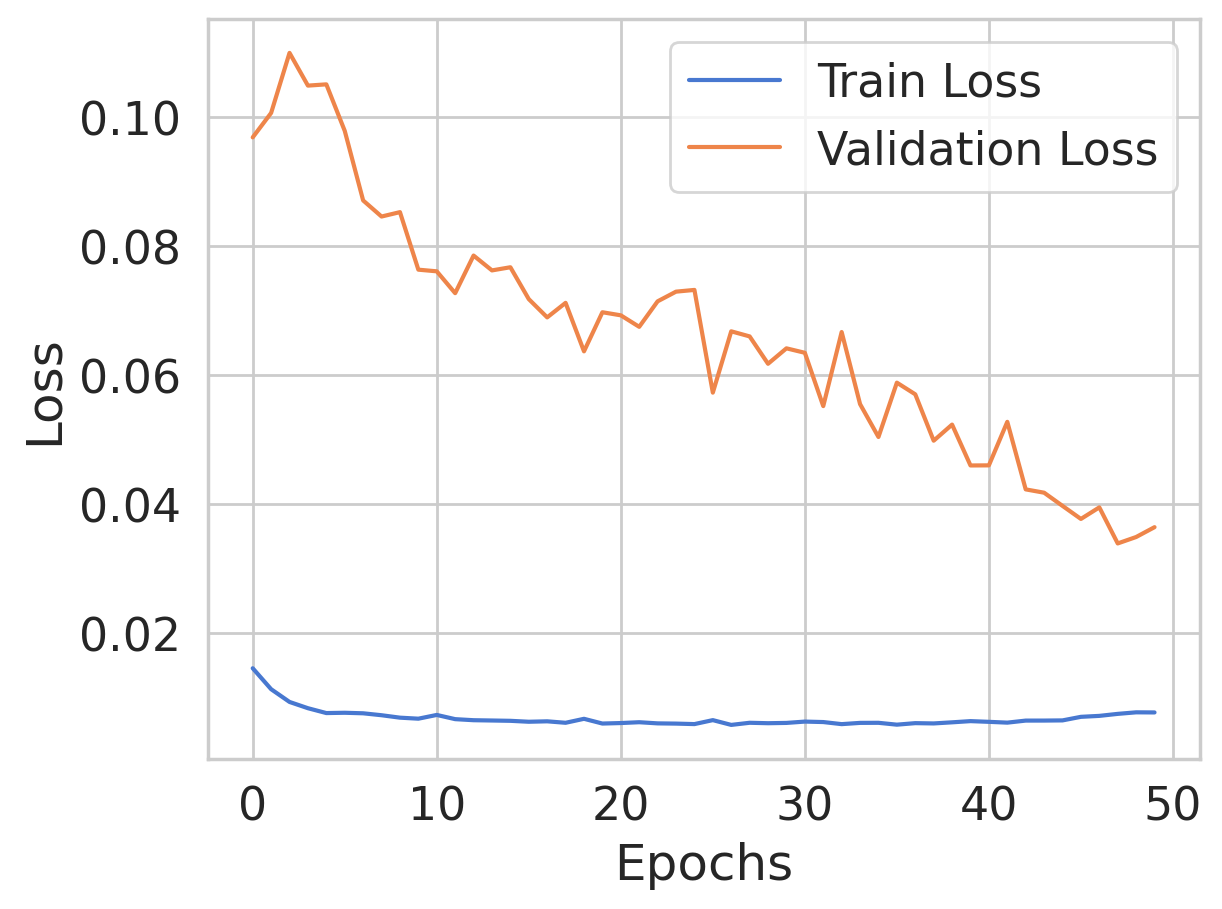

In [10]:
# Plot Training and Validation Loss

# Plot the training loss ('loss') and validation loss ('val_loss') from the history object.
# The history object records loss and validation loss for each epoch during training.
pyplot.plot(history.history['loss'], label='Train Loss')  # Plot training loss
pyplot.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Add labels and legend for better interpretability.
plt.xlabel("Epochs")  # Label for x-axis representing the number of epochs
plt.ylabel("Loss")  # Label for y-axis representing the loss values
pyplot.legend()  # Add a legend to differentiate between training and validation loss
pyplot.show()  # Display the plot

# Observations:
# - The test loss ('val_loss') is higher than the training loss ('loss').
# - This indicates that the model is NOT overfitting the data.
#
# Additionally:
# - Training and validation loss are printed at the end of each epoch.
# - The final RMSE (Root Mean Squared Error) of the model on the test dataset can be calculated or printed separately.

In [11]:
# Make a Prediction

# Generate predictions for the test dataset (X_test).
# The model's predict method outputs predictions based on the trained model.
y_pred = model.predict(X_test)

# Reshape X_test to prepare it for inverse scaling.
# This step ensures that the input has the correct dimensionality for concatenation.
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

# Invert scaling for the forecasted values:
# - Concatenate the predicted values with the rest of the feature columns (excluding the first column, which is the target).
# - Apply inverse transformation using the scaler to convert the normalized data back to its original scale.
y_pred_inv = concatenate((y_pred, X_test[:, 1:]), axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:, 0]  # Extract the target column (forecasted values).

# Invert scaling for the actual values:
# - Reshape the actual target values (y_test) to ensure compatibility for concatenation.
# - Concatenate with the feature columns from X_test.
# - Apply inverse transformation using the scaler to revert normalization.
y_test = y_test.reshape((len(y_test), 1))
y_inv = concatenate((y_test, X_test[:, 1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:, 0]  # Extract the target column (actual values).

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [12]:
# Evaluate Model Performance

# After the model is fit, forecasts are made for the entire test dataset.
# Both the forecasted values and actual test dataset values are already scaled back to their original units.

# Calculate Root Mean Squared Error (RMSE):
# RMSE provides an error score in the same units as the target variable,
# making it intuitive to interpret the model's predictive accuracy.
rmse = sqrt(mean_squared_error(y_inv, y_pred_inv))

# Print the Test RMSE
# This score represents the average deviation of predictions from actual values in the same units as the target.
print('Test RMSE: %.3f' % rmse)

Test RMSE: 146.147


## Results and Analysis

In [13]:
# Compare Actual and Predicted Values

# Create a DataFrame to organize and compare the actual (real) and forecasted (predicted) values.
# - "Level real": Contains the actual values of the target variable after inverse scaling.
# - "Level forecast": Contains the forecasted values generated by the LSTM model, also after inverse scaling.
y_comparison = pd.DataFrame({
    "Level real": y_inv,        # Actual target values
    "Level forecast": y_pred_inv  # Predicted target values
})

# Display the first few rows of the comparison DataFrame for a quick overview.
y_comparison.head()

,Level real,Level forecast
0,2880.0,2505.746094
1,2872.0,2500.914307
2,2864.0,2496.071289
3,2856.0,2491.217285
4,2849.0,2486.352051


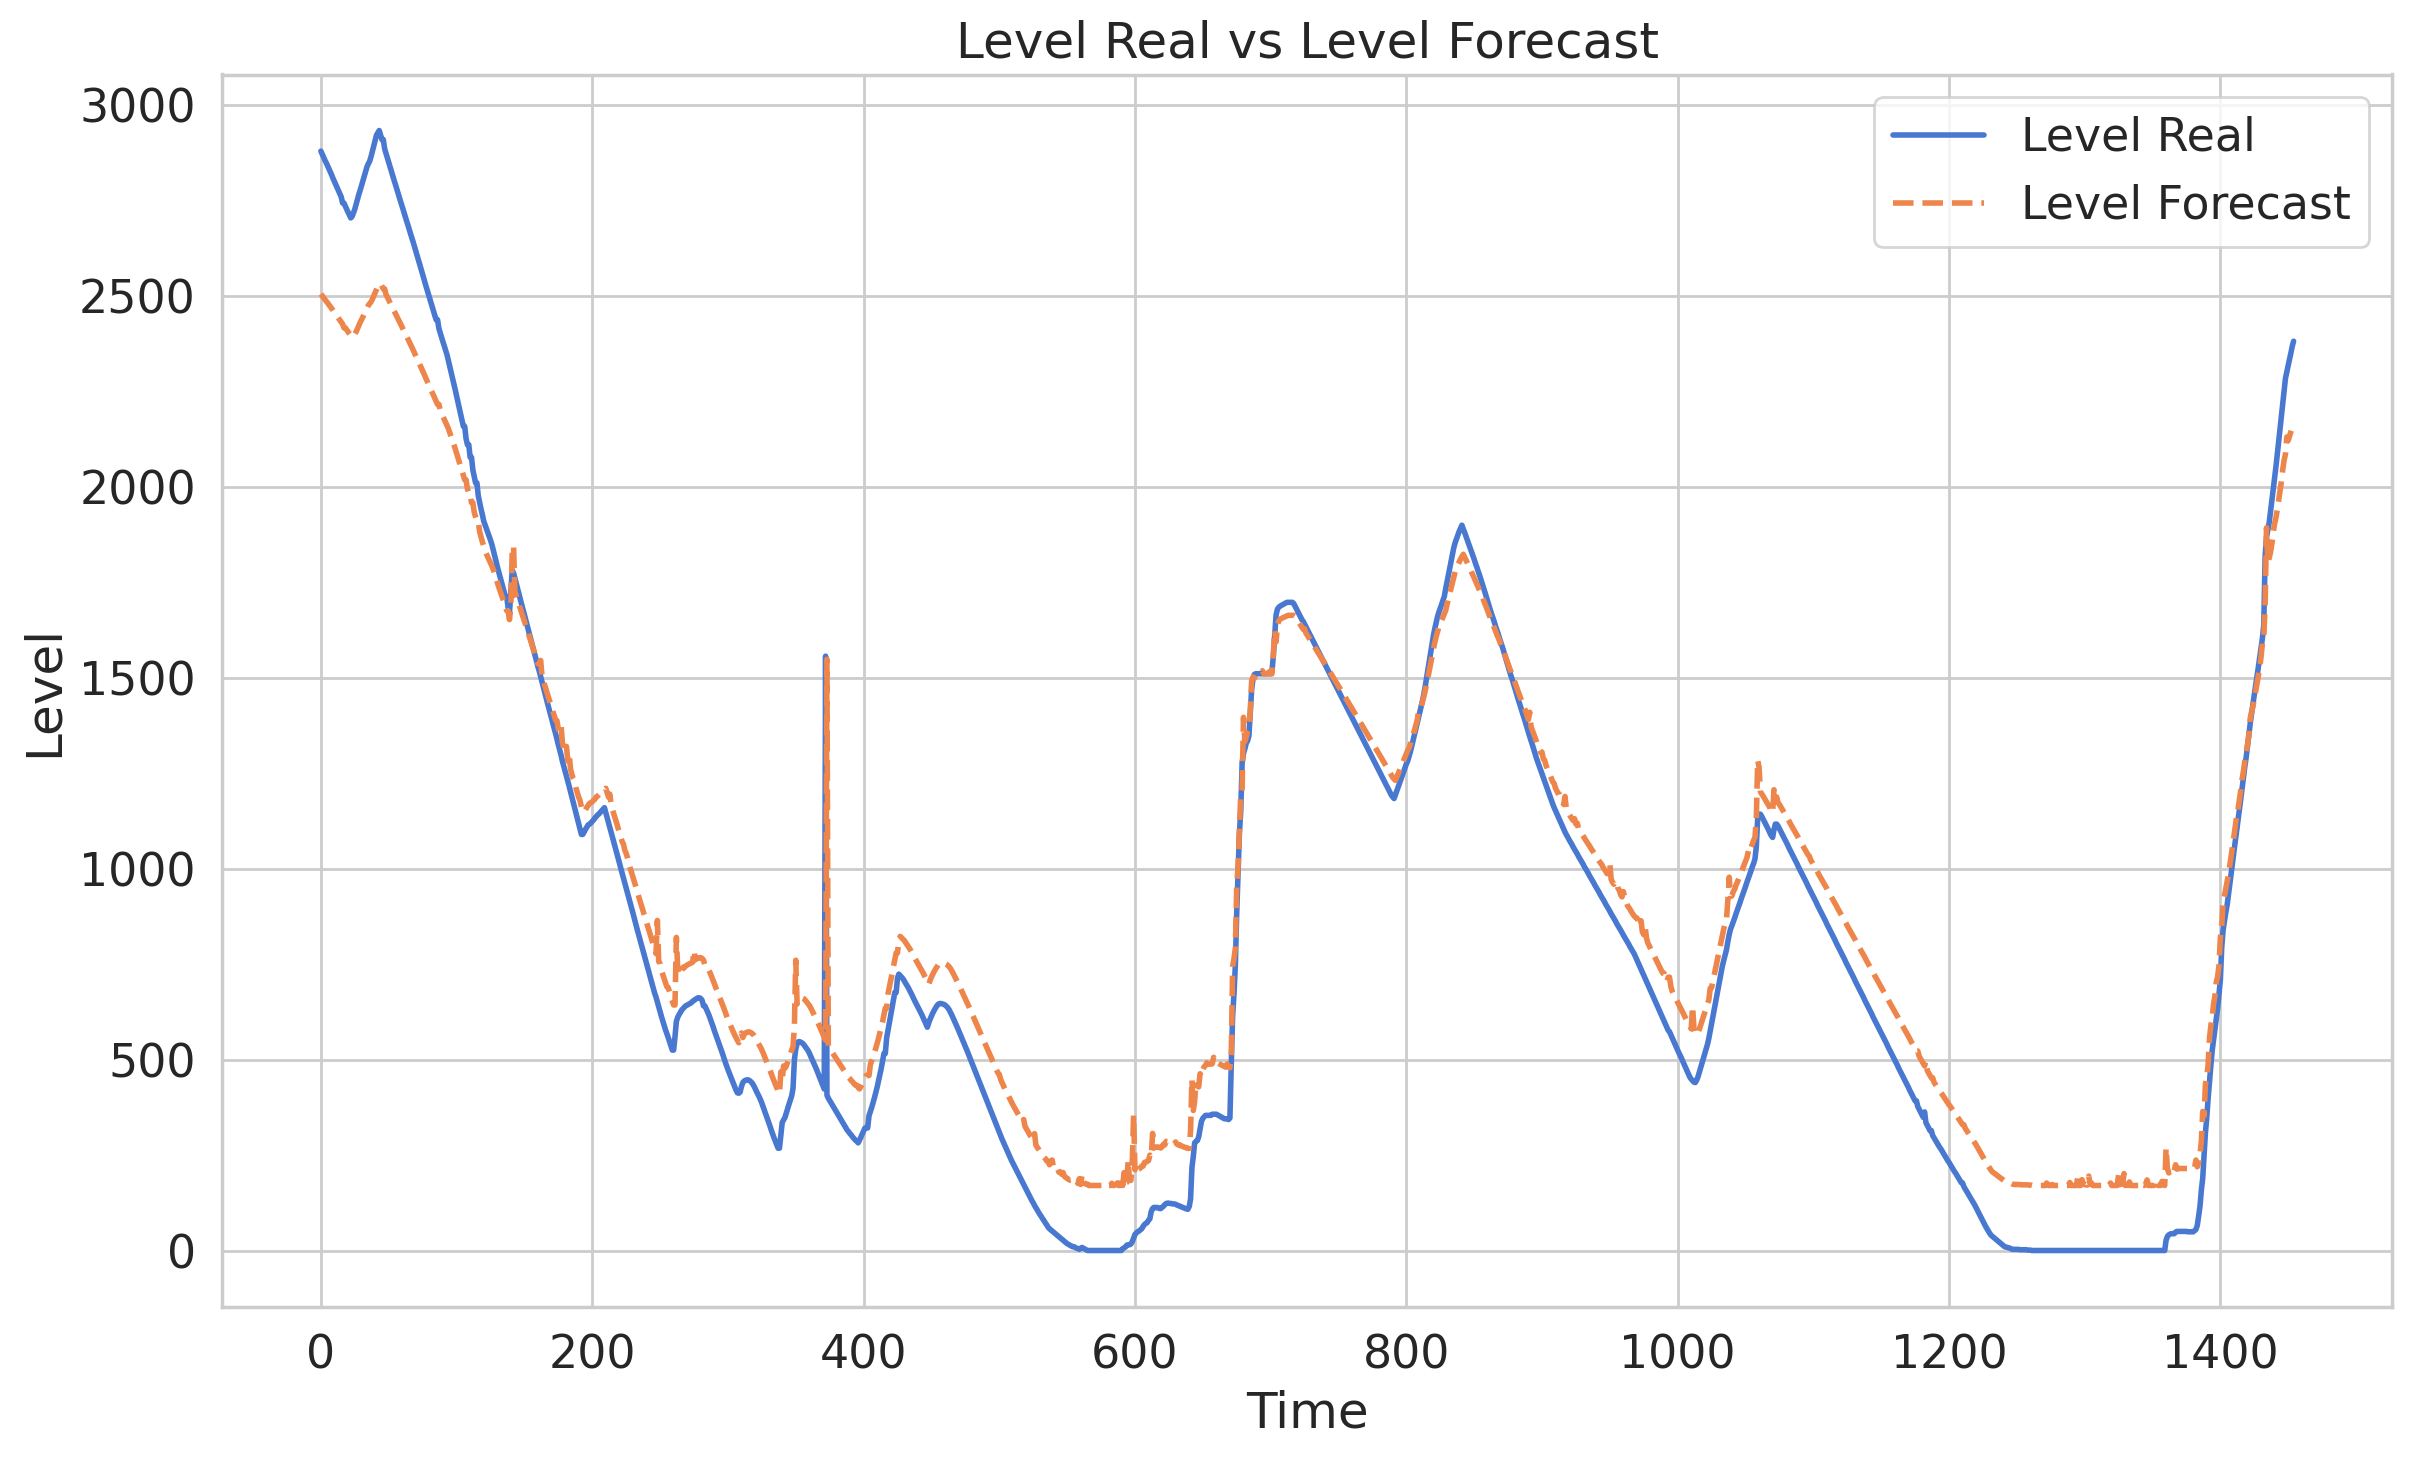

In [14]:
# Plot Actual vs Predicted Values

# Create a plot to visualize and compare the actual ("Level real") and predicted ("Level forecast") values over time.

plt.figure(figsize=(14, 8))  # Set the figure size for better visibility
plt.title("Level Real vs Level Forecast")  # Add a title to the plot

# Plot the actual values ("Q real") in the comparison DataFrame
plt.plot(y_comparison["Level real"], label="Level Real", linestyle='-', linewidth=2)

# Plot the predicted values ("Q forecast") in the comparison DataFrame
plt.plot(y_comparison["Level forecast"], label="Level Forecast", linestyle='--', linewidth=2)

# Add labels for the x-axis (Time) and y-axis (Q)
plt.xlabel("Time")
plt.ylabel("Level")

# Add a legend to differentiate between the actual and predicted values
plt.legend()

# Display the plot
plt.show()
